In [1]:
try:
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    !pip install linearmodels -q
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
data.variable_labels()

{'cusip': 'CUSIP',
 'year': 'year',
 'xrd': 'Expenditure on R&D',
 'ppent': 'Net book value of property, plant and equipment',
 'spillsic': 'SIC correlation weighted R&D of other firms, 1996 values',
 'spillcovsic': '',
 'spillmalsic': '',
 'spillmalcovsic': '',
 'spilltec': 'Patent NClass correlation weighted R&D of other firms, 1996 values',
 'spillcovtec': '',
 'spillmaltec': '',
 'spillmalcovtec': '',
 'spilltloc': '',
 'spillsloc': '',
 'spilltectloc': '',
 'spilltecsloc': '',
 'spillsicsloc': '',
 'spillsictloc': '',
 'lstate': '',
 'lfirm': '',
 'firm_dum': '',
 'hxrd': '',
 'spillsicIV': '',
 'spilltecIV': '',
 'spillsicIV_mal': '',
 'spilltecIV_mal': '',
 'p005': '',
 'sales_ind': 'Control variable - Total sales weighted by sic sales matrix',
 'sales_ind_ns': 'Control variable - Total Value Shipments in Manufacturing from National Statisti',
 'patents_ind': 'Control variable - Total number of patents weighted by tech matrix',
 'pat_count': 'Patents per firm applied for that ye

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

/tmp/ipykernel_154/3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
/tmp/ipykernel_154/3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# filter dataframe to variables of interest
df = df.drop(columns=['grd','grd_k1','pat_cite'])

# delete NaN values
df = df.dropna(axis=0)

#for i in range(0, len(var_of_int_noindex)):
#    df = df[df[var_of_int_noindex[i]].isna() == False]

#df = df.loc[df['rmkvaf'].isna() == False]

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

,rmkvaf,gspilltecIV,gspillsicIV,pat_count,rsales,rppent,emp,rxrd
count,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00,13385.00
mean,3863.04,21341.64,6164.57,16.85,2852.77,1309.39,18.68,106.59
std,16402.81,16288.44,9019.92,75.96,8782.54,4070.72,53.65,473.90
min,0.43,230.28,4.31,0.00,1.08,0.91,0.10,0.00
25%,88.34,8991.68,607.00,0.00,117.32,27.22,1.09,0.00
50%,409.62,17508.95,2067.49,1.00,450.26,121.87,3.85,4.68
75%,1990.41,29810.46,7534.20,5.00,1950.00,731.75,14.00,30.19
max,485566.69,92324.67,55576.60,2405.00,140609.58,72825.98,876.80,8900.00


In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
rmkvaf & 13385.000000 & 3863.040000 & 16402.810000 & 0.430000 & 88.340000 & 409.620000 & 1990.410000 & 485566.690000 \\
gspilltecIV & 13385.000000 & 21341.640000 & 16288.440000 & 230.280000 & 8991.680000 & 17508.950000 & 29810.460000 & 92324.670000 \\
gspillsicIV & 13385.000000 & 6164.570000 & 9019.920000 & 4.310000 & 607.000000 & 2067.490000 & 7534.200000 & 55576.600000 \\
pat_count & 13385.000000 & 16.850000 & 75.960000 & 0.000000 & 0.000000 & 1.000000 & 5.000000 & 2405.000000 \\
rsales & 13385.000000 & 2852.770000 & 8782.540000 & 1.080000 & 117.320000 & 450.260000 & 1950.000000 & 140609.580000 \\
rppent & 13385.000000 & 1309.390000 & 4070.720000 & 0.910000 & 27.220000 & 121.870000 & 731.750000 & 72825.980000 \\
emp & 13385.000000 & 18.680000 & 53.650000 & 0.100000 & 1.090000 & 3.850000 & 14.000000 & 876.800000 \\
rxrd & 13385.000000 & 106.590000 & 473.900000 & 0.000000 & 0.000000 & 4.

# OLS Regression

In [8]:
# Run linear model
# gen fixed effects
time_effects = pd.get_dummies(df['year'])
#time_effects.columns = time_effects.columns.astype(str)
firm_effects = pd.get_dummies(df['i'])
#time_effects.columns = time_effects.columns.astype(str)

In [9]:
# set up panel data for PanelOLS
df_pl = df
df_pl['year'] = df_pl['year'].astype(int)
df_pl = df_pl.set_index(['i','year'])

In [10]:
df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

df = df.rename(columns={'key_0': 'old_key'})

df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

fixed_effects = list(time_effects.columns.values)
for col in firm_effects.columns.values:
    fixed_effects.append(col)
    
# remove ref categories
#fixed_effects.remove('9999.0')
fixed_effects.remove('1980')

y_var = df['rmkvaf']

# get df for x vars + fixed effects
x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd','gspilltec','gspillsic']
for col in fixed_effects:
    x_vars.append(col)

In [11]:
x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

In [12]:
#lin_reg = sm.OLS(y_var,x_vars.drop(columns=['gspilltec','gspillsic'])).fit(cov_type='HC0')
#lin_regtec = sm.OLS(y_var,x_vars.drop(columns=['gspillsicIV','gspillsic'])).fit(cov_type='HC0')
#lin_regsic = sm.OLS(y_var,x_vars.drop(columns=['gspilltecIV','gspilltec'])).fit(cov_type='HC0')
panel_y = df_pl['rmkvaf']
panel_x = df_pl.drop(columns=['gspillsic','gspilltec','rmkvaf'])

lin_reg = PanelOLS(panel_y,panel_x,entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regtec = PanelOLS(panel_y,panel_x.drop(columns='gspillsicIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regsic = PanelOLS(panel_y,panel_x.drop(columns='gspilltecIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')

In [13]:
# 2SLS robustness check
iv_reg = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV']),
                   instrument=x_vars.drop(columns=['gspilltec','gspillsic'])).fit()

x_varsnofe = x_vars.drop(columns=firm_effects.columns)
iv_regnofe = IV2SLS(y_var,x_varsnofe.drop(columns=['gspilltecIV','gspillsicIV']),
                   instrument=x_varsnofe.drop(columns=['gspilltec','gspillsic'])).fit()


#iv_regtec = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV','gspillsic']),
#                   instrument=x_vars.drop(columns=['gspilltec','gspillsic','gspillsicIV'])).fit()
#iv_regsic = IV2SLS(y_var,x_vars.drop(columns=['gspilltecIV','gspillsicIV','gspilltec']),
#                   instrument=x_vars.drop(columns=['gspilltec','gspillsic','gspilltecIV'])).fit()

In [10]:
# export results, omit fixed effects
stargazer = Stargazer([lin_regtec,iv_regtec,lin_regsic,iv_regsic,lin_reg,iv_reg])

main_vars = [col for col in x_vars.columns if col not in fixed_effects]
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': '',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures'}


stargazer.covariate_order(main_vars)
stargazer.custom_columns(['OLS', '2SLS','OLS', '2SLS','OLS', '2SLS'], [1, 1, 1, 1, 1, 1])
stargazer.add_line("Firm & Time Effects", ['Yes','Yes','Yes','Yes','Yes','Yes'])
#stargazer.rename_covariates(cov_labels)
stargazer

In [11]:
# render to latex
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: rmkvaf}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 const & -9940.577$^{***}$ \\
& (2385.347) \\
 gspilltecIV & 0.100$^{***}$ \\
& (0.027) \\
 gspillsicIV & 0.340$^{***}$ \\
& (0.049) \\
 pat_count & -30.602$^{***}$ \\
& (1.838) \\
 rsales & 0.781$^{***}$ \\
& (0.037) \\
 rppent & 0.611$^{***}$ \\
& (0.084) \\
 emp & 18.064$^{**}$ \\
& (7.147) \\
 rxrd & 18.594$^{***}$ \\
& (0.614) \\
 Firm & Time Effects & Yes \\
\hline \\[-1.8ex]
 Observations & 13385 \\
 $R^2$ & 0.665 \\
 Adjusted $R^2$ & 0.645 \\
 Residual Std. Error & 9771.830 (df=12629) \\
 F Statistic & 33.221$^{***}$ (df=755; 12629) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# Ridge Regression

In [12]:
# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns or col in fixed_effects])).fit(df)
Y = np.array(df['rmkvaf'])
X = design.transform(df)

D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [13]:
df[['i','rmkvaf']].sort_values('rmkvaf', ascending=False)

,i,rmkvaf
904,20779.0,436988.531250
9175,8530.0,271724.750000
9176,8530.0,228610.859375
7418,7257.0,202124.515625
903,20779.0,194111.171875
...,...,...
11426,10215.0,0.756740
10890,9799.0,0.718651
9447,8681.0,0.634273
10891,9799.0,0.617000


In [14]:
design

ModelSpec(terms=Index(['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspilltecIV',
       'gspillsicIV'],
      dtype='object'))

In [15]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097622458263.0627, tolerance: 219554957.16334796
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective di

In [16]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

soln_path

,rxrd,pat_count,rsales,rppent,emp,gspilltecIV,gspillsicIV
negative log(lambda),,,,,,,
-8.997627,0.892316,0.424800,0.842053,0.725879,0.597987,0.388765,0.325032
-8.765043,1.125856,0.535961,1.062429,0.915848,0.754468,0.490504,0.410105
-8.532459,1.420481,0.676185,1.340440,1.155497,0.951864,0.618847,0.517433
-8.299874,1.792144,0.853057,1.691136,1.457798,1.200849,0.780738,0.652830
-8.067290,2.260952,1.076129,2.133482,1.839098,1.514876,0.984929,0.823623
...,...,...,...,...,...,...,...
13.097886,4847.562838,-405.321162,2395.633459,1591.688181,-1205.604869,167.101411,1176.284323
13.330471,4847.567994,-405.322699,2395.633438,1591.688347,-1205.608144,167.100739,1176.284323
13.563055,4847.572079,-405.323918,2395.633421,1591.688479,-1205.610740,167.100207,1176.284324


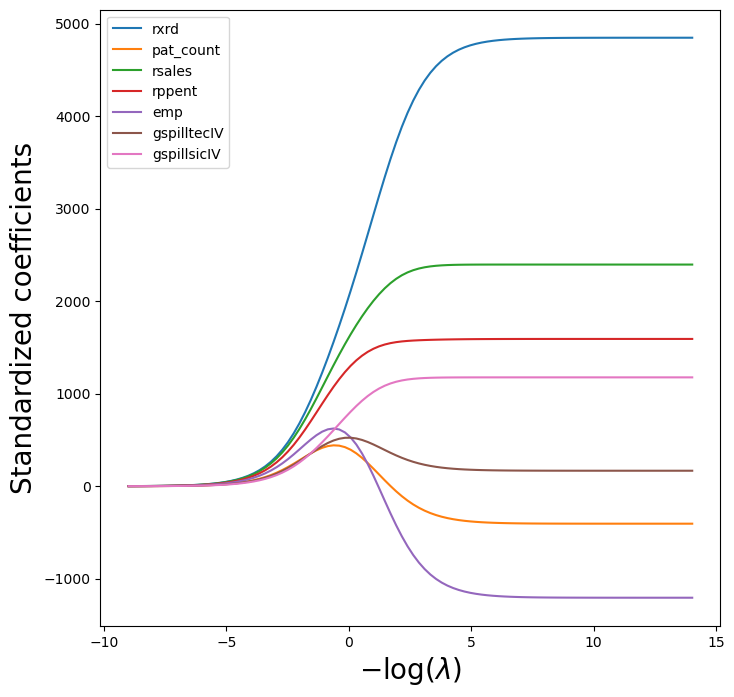

In [17]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

# save figure
plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [18]:
# # Using K-fold CV w/ K=5
# K = 5
# kfold = skm.KFold(K,
#                   random_state=0,
#                   shuffle=True)

# scaler = StandardScaler(with_mean=True,  with_std=True)
# ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
# pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

# param_grid = {'ridge__alpha': lambdas}

# grid = skm.GridSearchCV(pipe,
#                         param_grid,
#                         cv=kfold,
#                         scoring='neg_mean_squared_error') 
# grid.fit(X, Y)
# grid.best_params_['ridge__alpha']
# grid.best_estimator_

# ridgeCV = lm.ElasticNetCV(alphas=lambdas,
#                            l1_ratio=0,
#                            cv=kfold)
# pipeCV = Pipeline(steps=[('scaler', scaler),
#                          ('ridge', ridgeCV)])
# pipeCV.fit(X, Y)

# tuned_ridge = pipeCV.named_steps['ridge']

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316873049894.24744, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316857801712.4983, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordina

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311051219264.0425, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305030072647.7236, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+11, tolerance: 1.272e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [19]:
# # Plot results
# ridge_fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(-np.log(lambdas),
#             -grid.cv_results_['mean_test_score'],
#             yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# #ax.set_ylim([80000000,220000000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20)

# # save figure
# plt.savefig('ridge_cv.png')

# LASSO Regression

In [20]:
# lassoCV = lm.ElasticNetCV(n_alphas=100,
#                            l1_ratio=1,
#                            cv=kfold)
# pipeCV = Pipeline(steps=[('scaler', scaler),
#                          ('lasso', lassoCV)])
# pipeCV.fit(X, Y)
# tuned_lasso = pipeCV.named_steps['lasso']
# tuned_lasso.alpha_

In [21]:
# lambdas, soln_array = lm.Lasso.path(Xs,
#                                     Y,
#                                     l1_ratio=1,
#                                     n_alphas=100)[:2]
# soln_path = pd.DataFrame(soln_array.T,
#                          columns=D.columns,
#                          index=-np.log(lambdas))

In [22]:
# path_fig, ax = plt.subplots(figsize=(10,5))
# soln_path.plot(ax=ax, legend=False)
# ax.legend(loc='upper left')
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Standardized coefficiients', fontsize=20)

# # save figure
# plt.savefig('lasso_coef.png')

## Cross-Validation plot

In [23]:
# lassoCV_fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(-np.log(tuned_lasso.alphas_),
#             tuned_lasso.mse_path_.mean(1),
#             yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
# ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# #ax.set_ylim([50000,250000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20)

# # save figure
# plt.savefig('lasso_cv.png')

In [24]:
# # comparing lambdas

# # tuned alphas
# print("LASSO: ", tuned_lasso.alpha_)
# print("Ridge: ", tuned_ridge.alpha_)

In [25]:
# print(-np.log(tuned_lasso.alpha_))

# Regression Tree

In [26]:
# Splitting sample
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

In [27]:
# reg = DTR(max_depth=3)
# reg.fit(X_train, y_train)
# ax = plt.subplots(figsize=(12,12))[1]
# plot_tree(reg,
#           feature_names=feature_names,
#           ax=ax);

In [28]:
# # Find best pruning for tree
# ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
# kfold = skm.KFold(5,
#                   shuffle=True,
#                   random_state=10)
# grid = skm.GridSearchCV(reg,
#                         {'ccp_alpha': ccp_path.ccp_alphas},
#                         refit=True, # retrains on best alpha
#                         cv=kfold,
#                         scoring='neg_mean_squared_error')
# G = grid.fit(X_train, y_train)

In [29]:
# # Get prediction error
# best_ = grid.best_estimator_
# tree_mse = np.mean((y_test - best_.predict(X_test))**2)
# tree_mse

In [30]:
# # Output pruned Regression Tree
# ax = plt.subplots(figsize=(12,12))[1]
# plot_tree(G.best_estimator_,
#           feature_names=feature_names,
#           ax=ax);
# plt.savefig("pruned_tree.png")

# Random Forest

In [31]:
RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

In [32]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
rxrd,0.303054
rsales,0.230557
rppent,0.142841
gspillsicIV,0.111545
emp,0.105906
gspilltecIV,0.066526
pat_count,0.039571


Text(0.5, 1.0, 'Importance of Random Forest Regressors for Firm Market Value')

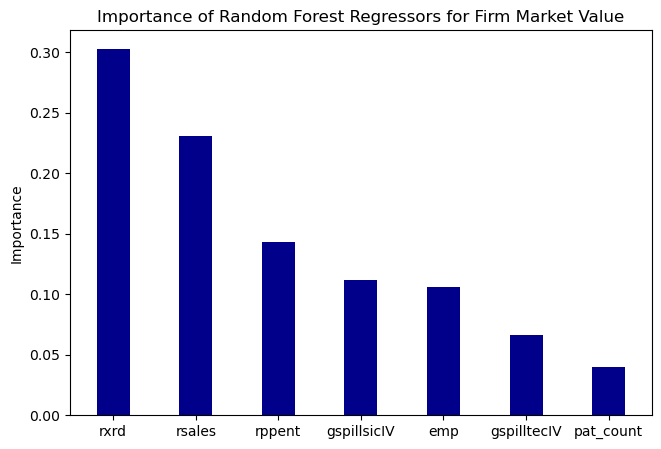

In [33]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# plot importance values
fig = plt.figure(figsize=(7.5,5))

plt.bar(feature_imp.index, feature_imp.importance, color ='darkblue', 
        width = 0.4)
plt.ylabel('Importance')
plt.title('Importance of Random Forest Regressors for Firm Market Value')

# Bagging

In [34]:
# bag = RF(max_features=X_train.shape[1], random_state=0)
# bag.fit(X_train, y_train)

In [35]:
# ax = plt.subplots(figsize=(8,8))[1]
# y_hat_bag = bag.predict(X_test)
# ax.scatter(y_hat_bag, y_test)
# bag_mse = np.mean((y_test - y_hat_bag)**2)
# bag_mse

# Boosting

In [36]:
# boost = GBR(n_estimators=5000, # Gradient Boosting Regressor
#                    learning_rate=0.001,
#                    max_depth=3,
#                    random_state=0)
# boost.fit(X_train, y_train)

In [37]:
# test_error = np.zeros_like(boost.train_score_)
# for idx, y_ in enumerate(boost.staged_predict(X_test)):
#    test_error[idx] = np.mean((y_test - y_)**2)

# plot_idx = np.arange(boost.train_score_.shape[0])
# ax = plt.subplots(figsize=(8,8))[1]
# ax.plot(plot_idx,
#         boost.train_score_,
#         'b',
#         label='Training')
# ax.plot(plot_idx,
#         test_error,
#         'r',
#         label='Test')
# ax.legend();

# boost_mse = min(test_error)

In [38]:
# # XG Boost
# y = df['rmkvaf']
# # Convert the data into XGBoost's DMatrix format
# dtrain = xgb.DMatrix(X, label=y)

# # Define the parameters for the XGBoost model
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.1,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# # Train the XGBoost model with the optimal number of boosting rounds
# model = xgb.train(params, dtrain, num_boost_round= 10)

# # Make predictions 
# y_pred = model.predict(dtrain)

# # Calculate and print the Mean Squared Error (MSE)
# mse = mean_squared_error(y, y_pred)
# print("Mean Squared Error:", mse)
# print("Prev. MSE: 40865396.0")

# plt.figure(figsize=(8, 6))
# plt.scatter(y, y_pred, c='grey', alpha=0.3)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# plt.xlabel('True Y')
# plt.ylabel('Predicted Y')
# plt.title('Y vs Predicted Y (Y hat)')
# plt.show()

# Comparing Test Errors

In [39]:
# # Tree
# print('Tree: ', tree_mse)
# # Bag
# print('Bag: ', bag_mse)
# # Random Forest
# print('Random Forest: ', rf_mse)
# # Boost
# print('Boost: ', boost_mse)

# # Make table
# error_tbl = {
#     'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
#     'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
# }
# error_tbl = pd.DataFrame(data=error_tbl)
# print(error_tbl.to_latex())

# Predicting Market value of spillovers across years

In [40]:
# # Use Optimal LASSO coefficients - remember to rescale from their standardization back to unit values.
# print(x_vars.columns[1],': ',tuned_lasso.coef_[0]) # index 0 for x_vars is constant term
# print(x_vars.columns[2],': ',tuned_lasso.coef_[1]) # so 1st variable is at index 1


In [41]:
# # rescaling lasso coefficients
# coef_tec = tuned_lasso.coef_[0]/df['gspilltecIV'].std()
# coef_sic = tuned_lasso.coef_[1]/df['gspillsicIV'].std() 

In [42]:
# df['firmval_tec'] = df['gspilltecIV']*coef_tec
# df['firmval_sic'] = df['gspillsicIV']*coef_sic

In [43]:
# df[['rmkvaf','firmval_tec','firmval_sic']]

In [44]:
# print(df['rmkvaf'].sum())
# print(df['firmval_tec'].sum())
# # Generate predictions for each firm

# # Aggregate across years

In [16]:
# Using simple regression

# tech spillovers - resume later as I have methodological issues
# drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
# x_vars_fe = x_vars.drop(columns=drop_columns)
# y_var = df['rmkvaf']

# tech_ml = sm.OLS(y_var,x_vars_fe[['const','gspilltecIV']]).fit()
# tech_ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1024.
Date:                Fri, 18 Oct 2024   Prob (F-statistic):          1.37e-216
Time:                        21:15:30   Log-Likelihood:            -1.4840e+05
No. Observations:               13385   AIC:                         2.968e+05
Df Residuals:                   13383   BIC:                         2.968e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1866.7954    225.240     -8.288      0.000   -2308.298   -1425.293
gspilltecIV     0.2685      0.008     32.001      0.000       0.252       0.285
==============================================================================
Omnibus:                    24575.574   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         45334900.070
Skew:                          13.624   Prob(JB):                         0.00
Kurtosis:                     286.805   Cond. No.                     4.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Impact of spillovers on firm value over time

In [36]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers

# build year-spillover interaction terms
years = df.year.sort_values().unique()
years = years[1:] # remove first year as ref category

spillovers = ['gspilltecIV','gspillsicIV']

for spillover in spillovers:
    for year in years:
        col_name = f"{spillover}X{year}"
        x_vars[col_name] = x_vars[spillover]*x_vars[year]

# drop reference year dummy
#x_vars = x_vars.drop(columns=['1981'])
#fixed_effects.remove('1981')

In [ ]:
# Estimate effect of spillovers on firm value, OLS w/o firm FE's. Estimate spillovers separately, then together.

# Full model
# year_model1 = sm.OLS(y_var,x_vars).fit(cov_type='HC0')
# year_model1.summary()

In [37]:
# Tech spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# year_model2 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# year_model2.summary()

In [38]:
# Tech spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

# year_model3 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
# year_model3.summary()

In [ ]:
# Tech spillovers, all FE's, 5 year intervals


Results highly depend on the firm FE's. Wrong sign for tech, insignificant for product market. Unobserved firm-related variables play a role?

In [17]:
# Product spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# year_model4 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# year_model4.summary()

In [19]:
# Product spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

year_model5 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
year_model5.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 754, but rank is 751
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     37.37
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:23:24   Log-Likelihood:            -1.4158e+05
No. Observations:               13385   AIC:                         2.847e+05
Df Residuals:                   12630   BIC:                         2.903e+05
Df Model:                         754                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6828.7722   1686.507     -4.049      0.000   -1.01e+04   -3523.280
gspillsicIV     0.4143      0.097      4.254      0.000       0.223       0.605
pat_count     -31.0864      5.725     -5.429      0.000     -42.308     -19.865
rsales          0.8033      0.236      3.406      0.001       0.341       1.266
rppent          0.6202      0.484      1.283      0.200      -0.328       1.568
emp            13.2757     22.454      0.591      0.554     -30.734      57.285
rxrd           18.6616      5.098      3.661      0.000       8.670      28.653
1981         -376.9768    451.861     -0.834      0.404   -1262.608     508.655
1982         -202.0395    461.821     -0.437      0.662   -1107.193     703.114
1983         -158.5555    443.134     -0.358      0.720   -1027.082     709.971
1984         -612.0807    428.558     -1.428      0.153   -1452.039     227.878
1985         -668.3837    423.645     -1.578      0.115   -1498.713     161.945
1986         -854.4257    432.238     -1.977      0.048   -1701.597      -7.255
1987         -988.6666    431.795     -2.290      0.022   -1834.970    -142.364
1988        -1254.8298    444.313     -2.824      0.005   -2125.668    -383.992
1989        -1065.0604    442.534     -2.407      0.016   -1932.411    -197.710
1990        -1514.5023    457.563     -3.310      0.001   -2411.308    -617.696
1991        -1053.3229    447.479     -2.354      0.019   -1930.366    -176.280
1992        -1132.6042    446.320     -2.538      0.011   -2007.375    -257.834
1993        -1015.2063    441.925     -2.297      0.022   -1881.363    -149.050
1994        -1195.6403    468.105     -2.554      0.011   -2113.109    -278.171
1995         -578.1492    484.676     -1.193      0.233   -1528.097     371.798
1996         -198.9419    549.283     -0.362      0.717   -1275.516     877.633
1997          316.9837    589.939      0.537      0.591    -839.275    1473.242
1998          547.9392    685.217      0.800      0.424    -795.061    1890.939
1999         1371.6457    823.370      1.666      0.096    -242.129    2985.420
2000         1110.6290    989.390      1.123      0.262    -828.540    3049.798
2001         -888.8305    843.663     -1.054      0.292   -2542.379     764.718
10005.0      6606.7101   1634.417      4.042      0.000    3403.311    9810.109
10006.0      6787.0368   1654.626      4.102      0.000    3544.029       1e+04
10008.0      6229.1715   1535.492      4.057      0.000    3219.662    9238.681
10016.0      7113.8634   1681.988      4.229      0.000    3817.227    1.04e+04
10030.0      7097.2995   1724.919      4.115      0.000    3716.520    1.05e+04
1004.0       7121.8602   1722.890      4.134      0.000    3745.058    1.05e+04
10056.0      5497.1059   1483.147      3.706      0.000    2590.191    8404.021
10085.0      2192.9675    874.240      2.50

In [41]:
# Product Spillovers, all FE's, 5-year intervals

# Create 5-year intervals
#years = np.append(years,'1980')

df['1980_84'] = df['year'].isin(['1980','1981','1982','1983','1984'])
df['1985_89'] = df['year'].isin(['1985','1986','1987','1988','1989'])
df['1990_94'] = df['year'].isin(['1990','1991','1992','1993','1994'])
df['1995_99'] = df['year'].isin(['1995','1996','1997','1998','1999'])

x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']
intervals = ['1980_84','1985_89','1990_94','1995_99']
years = df.year.sort_values().unique()

for year in years:
    try:
        fixed_effects.remove(year)
    except ValueError:
        continue

for interval in intervals:
    fixed_effects.append(interval)

for col in fixed_effects:
    x_vars.append(col)

x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

for spillover in spillovers:
    for interval in intervals:
        col_name = f"{spillover}X{interval}"
        x_vars[col_name] = x_vars[spillover]*x_vars[interval]

In [53]:
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]

x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['1980_84', 'gspillsicIVX1980_84']) # drop ref category

y_var = df['rmkvaf']

int_modelsic = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
int_modelsic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     41.58
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:10:38   Log-Likelihood:            -1.3626e+05
No. Observations:               13325   AIC:                         2.740e+05
Df Residuals:                   12588   BIC:                         2.795e+05
Df Model:                         736                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9008.7612   1553.349     -5.800      0.000   -1.21e+04   -5963.961
gspillsicIV             0.5543      0.031     17.687      0.000       0.493       0.616
pat_count             -30.0707      1.310    -22.949      0.000     -32.639     -27.502
rsales                  0.4650      0.027     17.336      0.000       0.412       0.518
rppent                 -0.3084      0.061     -5.023      0.000      -0.429      -0.188
emp                    35.2988      5.035      7.011      0.000      25.429      45.168
rxrd                   16.0408      0.466     34.402      0.000      15.127      16.955
10005.0              8312.2154   2127.645      3.907      0.000    4141.708    1.25e+04
10006.0              8259.5186   2455.218      3.364      0.001    3446.917    1.31e+04
10008.0              7690.0800   2120.567      3.626      0.000    3533.446    1.18e+04
10016.0              9293.5084   2133.849      4.355      0.000    5110.839    1.35e+04
10030.0              8681.6681   2134.638      4.067      0.000    4497.453    1.29e+04
1004.0               8827.5471   2159.280      4.088      0.000    4595.030    1.31e+04
10056.0              6999.9097   2114.213      3.311      0.001    2855.730    1.11e+04
10085.0              2786.2102   2077.106      1.341      0.180   -1285.235    6857.655
10092.0              8427.5759   3765.724      2.238      0.025    1046.183    1.58e+04
10097.0              3084.4261   2093.586      1.473      0.141   -1019.321    7188.173
1010.0               9684.2465   3770.003      2.569      0.010    2294.465    1.71e+04
10109.0              8973.5015   2135.967      4.201      0.000    4786.680    1.32e+04
10115.0              6447.0489   2091.944      3.082      0.002    2346.519    1.05e+04
10124.0              9030.5948   2137.259      4.225      0.000    4841.241    1.32e+04
1013.0               4676.2511   2086.957      2.241      0.025     585.497    8767.005
10150.0              2793.2491   2414.603      1.157      0.247   -1939.740    7526.238
10159.0             -1279.4511   2985.833     -0.429      0.668   -7132.139    4573.237
10174.0              9039.0938   2319.634      3.897      0.000    4492.258    1.36e+04
10185.0              5820.4084   2246.651      2.591      0.010    1416.630    1.02e+04
10195.0             -1825.0618   2075.996     -0.879      0.379   -5894.331    2244.208
10198.0              8716.5775   2135.397      4.082      0.000    4530.873    1.29e+04
10215.0              8759.4516   2136.948      4.099      0.000    4570.707    1.29e+04
10232.0              3141.5015   2186.967      1.436      0.151   -1145.287    7428.290
10236.0              8171.1708   2127.463      3.841      0.000    4001.019    1.23e+04
10286.0              8303.2064   2178.831      3.811      0.000    4032.365    1.26e+04
103

In [55]:
# Tech spillovers, 5-year intervals
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]

x_vars_fe = x_vars.drop(columns=drop_columns)
x_vars_fe = x_vars_fe.drop(columns=['1980_84', 'gspilltecIVX1980_84']) # drop ref category

y_var = df['rmkvaf']

int_modeltec = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
int_modeltec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     40.65
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:13:26   Log-Likelihood:            -1.3636e+05
No. Observations:               13325   AIC:                         2.742e+05
Df Residuals:                   12588   BIC:                         2.797e+05
Df Model:                         736                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6696.3376   1598.275     -4.190      0.000   -9829.200   -3563.475
gspilltecIV             0.1464      0.013     11.389      0.000       0.121       0.172
pat_count             -29.7758      1.336    -22.281      0.000     -32.395     -27.156
rsales                  0.4535      0.027     16.551      0.000       0.400       0.507
rppent                 -0.3889      0.062     -6.296      0.000      -0.510      -0.268
emp                    35.0816      5.120      6.852      0.000      25.045      45.118
rxrd                   17.5450      0.461     38.033      0.000      16.641      18.449
10005.0              4243.7922   2128.728      1.994      0.046      71.161    8416.423
10006.0              3530.5343   2447.367      1.443      0.149   -1266.678    8327.747
10008.0              3221.4885   2112.167      1.525      0.127    -918.680    7361.657
10016.0              4208.8223   2117.857      1.987      0.047      57.499    8360.146
10030.0              5292.2265   2155.920      2.455      0.014    1066.294    9518.159
1004.0               4742.8585   2163.623      2.192      0.028     501.828    8983.889
10056.0              3905.3882   2127.224      1.836      0.066    -264.295    8075.071
10085.0              3144.6955   2108.985      1.491      0.136    -989.237    7278.628
10092.0              5580.8779   3799.536      1.469      0.142   -1866.793     1.3e+04
10097.0               411.0495   2102.883      0.195      0.845   -3710.923    4533.022
1010.0               5454.0678   3791.477      1.439      0.150   -1977.804    1.29e+04
10109.0              6482.9262   2183.315      2.969      0.003    2203.297    1.08e+04
10115.0              5805.7422   2133.050      2.722      0.007    1624.640    9986.845
10124.0              6520.1538   2185.490      2.983      0.003    2236.260    1.08e+04
1013.0               2802.0965   2100.303      1.334      0.182   -1314.818    6919.011
10150.0              1793.1496   2439.098      0.735      0.462   -2987.855    6574.154
10159.0              5869.6418   3054.531      1.922      0.055    -117.705    1.19e+04
10174.0              5358.1464   2337.410      2.292      0.022     776.466    9939.827
10185.0              5419.9076   2310.431      2.346      0.019     891.110    9948.705
10195.0              4994.8822   2143.485      2.330      0.020     793.325    9196.439
10198.0              5163.8845   2153.223      2.398      0.016     943.239    9384.530
10215.0              6180.0481   2182.759      2.831      0.005    1901.509    1.05e+04
10232.0              6883.1084   2283.281      3.015      0.003    2407.530    1.14e+04
10236.0              5426.3750   2159.072      2.513      0.012    1194.265    9658.485
10286.0              3499.6888   2166.784      1.615      0.106    -747.537    7746.915
103

## Graphing Product Market Spillovers over time

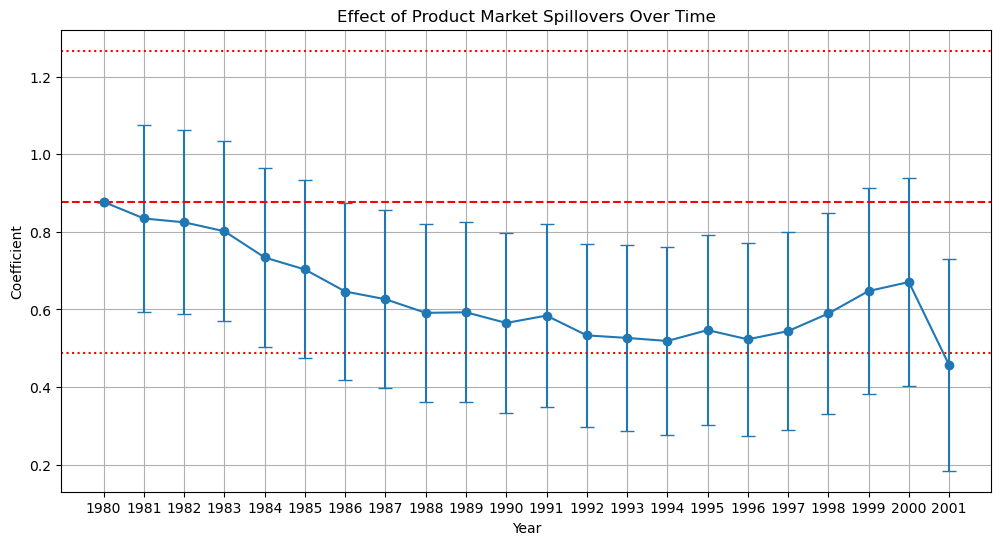

In [44]:
# grab estimates. Add non-interactive term to each year coefficient
# Build Dataframe of year, coefficient, conf intervals

# use years to interate through
# years = np.append(years, '1981')
# years = years.sort_values()

ref_year = '1980'
time_coefs_sic = {
    'year': np.append(years,ref_year),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model5.conf_int(alpha=0.05, cols=None)
s_errors = year_model5.HC0_se

# grab coefficients and confidence intervals
ref_year = '1980'
coef_ref = year_model5.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for year in time_coefs_sic['year'].unique():
    if year == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{year}"
        coef = year_model5.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h


time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['year'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['year'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='dashed', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Effect of Product Market Spillovers Over Time')
plt.grid(True)
plt.show()

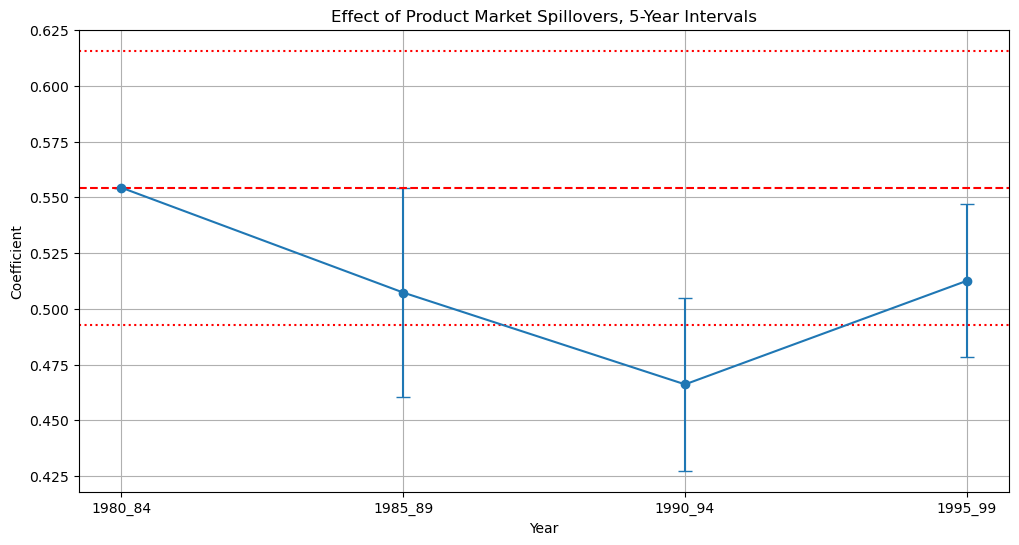

In [54]:
# Plot 5 Year Intervals

ref_year = '1980_84'
time_coefs_sic = {
    'interval': intervals,
    'coef': [np.nan for i in range(0,len(intervals))],
    'CI_l': [np.nan for i in range(0,len(intervals))],
    'CI_h': [np.nan for i in range(0,len(intervals))],
    'se': [np.nan for i in range(0,len(intervals))]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modelsic.conf_int(alpha=0.05, cols=None)
s_errors = int_modelsic.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modelsic.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for interval in time_coefs_sic['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{interval}"
        coef = int_modelsic.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h


time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['interval'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='dashed', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Effect of Product Market Spillovers, 5-Year Intervals')
plt.grid(True)
plt.show()

## Tech Spillovers over time

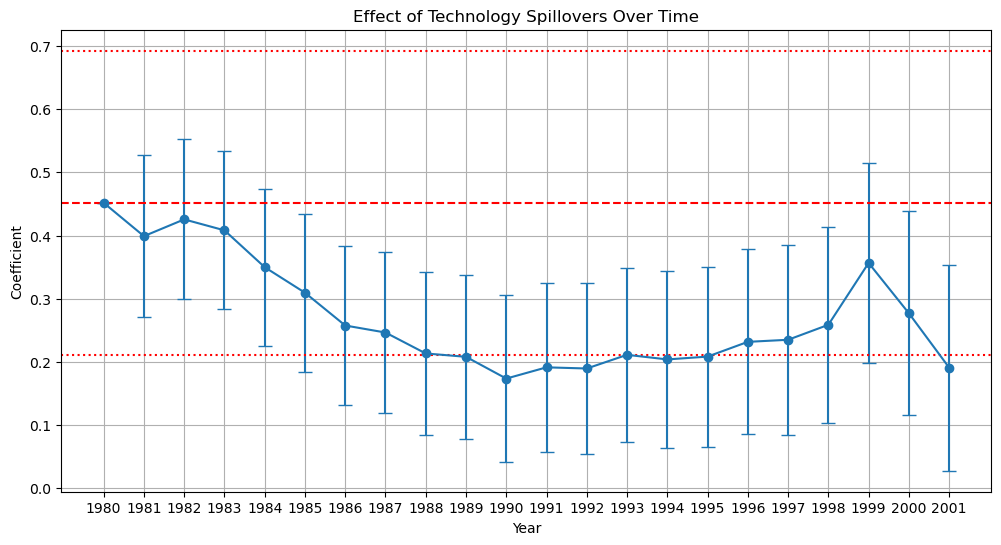

In [54]:
ref_year = '1980'
time_coefs_tec = {
    'year': np.append(years,ref_year),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_tec = pd.DataFrame(time_coefs_tec)
time_coefs_tec = time_coefs_tec.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model3.conf_int(alpha=0.05, cols=None)
s_errors = year_model3.HC0_se

# grab coefficients and confidence intervals
ref_year = '1980'
coef_ref = year_model3.params['gspilltecIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',1].values[0]

for year in time_coefs_tec['year'].unique():
    if year == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspilltecIVX{year}"
        coef = year_model3.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['year'] == year, 'CI_h'] = ci_h


time_coefs_tec['upper'] = time_coefs_tec['CI_h'] - time_coefs_tec['coef']
time_coefs_tec['lower'] = time_coefs_tec['coef'] - time_coefs_tec['CI_l']
time_coefs_tec.loc[time_coefs_tec['year'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_tec[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_tec['year'],y=time_coefs_tec['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='dashed', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Effect of Technology Spillovers Over Time')
plt.grid(True)
plt.show()

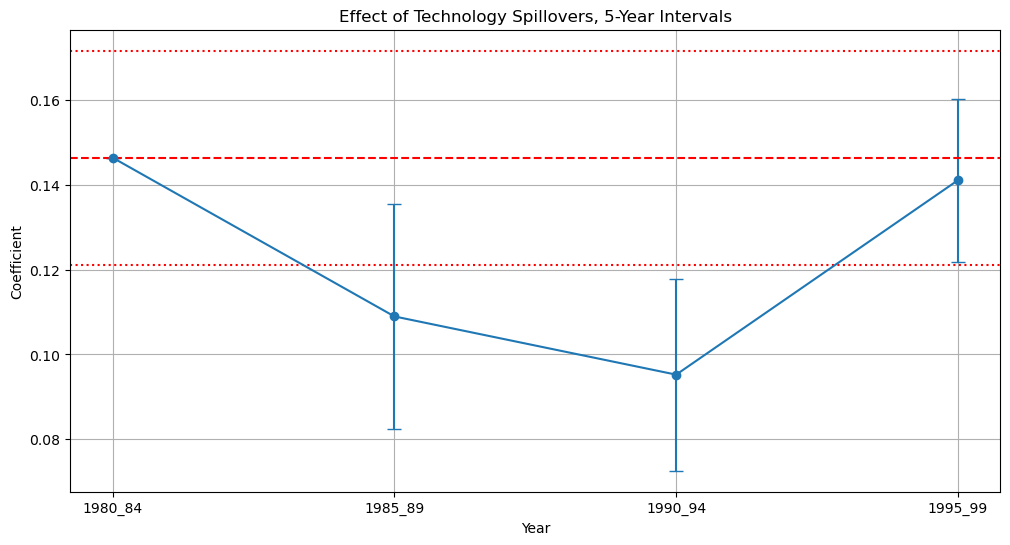

In [57]:
# Plot 5 Year Intervals, Tech spillovers

ref_year = '1980_84'
time_coefs_tec = {
    'interval': intervals,
    'coef': [np.nan for i in range(0,len(intervals))],
    'CI_l': [np.nan for i in range(0,len(intervals))],
    'CI_h': [np.nan for i in range(0,len(intervals))],
    'se': [np.nan for i in range(0,len(intervals))]
}

time_coefs_tec = pd.DataFrame(time_coefs_tec)
time_coefs_tec = time_coefs_tec.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modeltec.conf_int(alpha=0.05, cols=None)
s_errors = int_modeltec.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modeltec.params['gspilltecIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',1].values[0]

for interval in time_coefs_tec['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspilltecIVX{interval}"
        coef = int_modeltec.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h


time_coefs_tec['upper'] = time_coefs_tec['CI_h'] - time_coefs_tec['coef']
time_coefs_tec['lower'] = time_coefs_tec['coef'] - time_coefs_tec['CI_l']
time_coefs_tec.loc[time_coefs_tec['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_tec[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_tec['interval'],y=time_coefs_tec['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='dashed', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Effect of Technology Spillovers, 5-Year Intervals')
plt.grid(True)
plt.show()

# DAG model and testing

In [53]:
DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

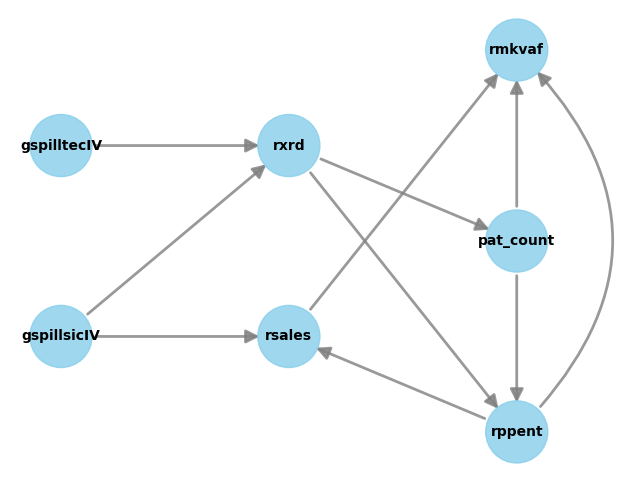

In [54]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [55]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[rmkvaf])
d[gspilltecIV]           
Estimand assumption 1, Unconfoundedness: If U→{gspilltecIV} and U→rmkvaf then P(rmkvaf|gspilltecIV,,U) = P(rmkvaf|gspilltecIV,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡                d                                ∂                          
E⎢──────────────────────────────────(rmkvaf)⋅──────────────([pat_count  rppent
 ⎣d[pat_count  rppent  rsales  rxrd]         ∂[gspilltecIV]                   

                ⎤
  rsales  rxrd])⎥
                ⎦
Estimand assumption 1, Full-mediation: pat_count,rppent,rsales,rxrd intercepts (blocks) all directed paths from gspilltecIV to r,m,k,v,a,f.
Estimand assumption 2, First-stage-unconfoundedness: If U→{gspilltecIV} and U→{pat_count,rppent,rsales,rxrd} then P(pat_count,

In [56]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

0.12296998685320659


In [57]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.12296998685320659
New effect:0.12347458135323676
p value:0.9199999999999999



# Scrap Code

X_spills = df[['gspilltecIV', 'gspillsicIV']]

(X_trainsp,
 X_testsp,
 y_trainsp,
 y_testsp) = skm.train_test_split(X_spills,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0) 

In [58]:
# # Try a neural network
# one_layers = [
#     (1),
#     (2),
#     (3),
#     (4),
#     (5)
# ]

# two_layers = [
#     (1,1),(1,2),(1,3),
#     (2,1),(2,2),(2,3),(2,4),
#     (3,1),(3,2),(3,3),(3,4),(3,5),
#     (4,1),(4,2),(4,3),(4,4),(4,5),
#     (5,1),(5,2),(5,3),(5,4),(5,5)
# ]

# # Use DML with a PLR equation, keeping spillovers entering linearly
# # Use Random Forest as the ML model

# # Specify doubleML data model

# x_vars = ['pat_count','rsales','rppent','emp','rxrd']
# data_dml_tec = dml.DoubleMLData(df,
#                                  y_col='rmkvaf',
#                                  d_cols='gspilltec',
#                                  x_cols=x_vars)

# RF_DML = RF(max_features=3, random_state=0)

# # Implement PLR DML estimation with gspilltec linear

# dml_plr_tec = dml.DoubleMLPLR(data_dml_tec,
#                                 ml_l = RF_DML,
#                                 ml_m = RF_DML,
#                                 n_folds = 3)

# dml_plr_tec.fit(store_predictions=True)
# print(dml_plr_tec.summary)